In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [2]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

# simulating an autoregressive moving average process

before jumping into using a dataset, we will create a $ARMA(p,q)$ process, specifically a $ARMA(1,1)$ process defined by the equation:

$y_t = 0.33y_{t–1} + 0.9\epsilon_{t–1} + \epsilon_{t}$

Let's remember that $ARMA(1,1)$ is defined by:

$ARMA(1,1) := y_t = C + \phi_1y_{t-1} + \mu + \theta\epsilon_{t-1}+ \epsilon{t}$

So you might be wondering where is $\mu$ and $C$, well in the first equation they are equal to $0$. So let's not worry about them right now

The purpose of this simulation is to show that we cannot use the old plots we are used to: ACF and PACF, to get $p$ and $q$ anymore

In [3]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

In [4]:
arma_process = sm.tsa.ArmaProcess(ar1, ma1).generate_sample(nsample = 1000)

now that we have our process let's do the steps.

In [5]:
adf = sm.tsa.stattools.adfuller(arma_process)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -6.429878682042654
p-value 1.7078466680100388e-08


since $p < 0.05$ we can reject the null hypothesis and conclude that we have a stationary process.

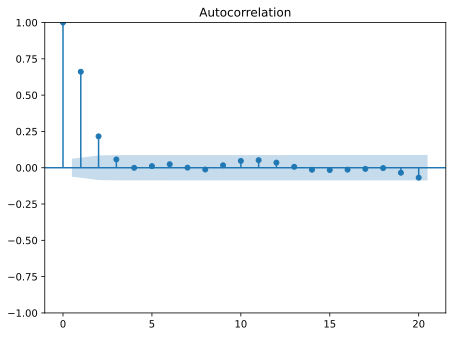

In [6]:
sm.graphics.tsa.plot_acf(arma_process, lags = 20)
plt.tight_layout()

we can see a sinusoidal pattern in the plot, and the last significant lag is 2. Take into account that we did our process specifically to be MA(1) so this plot is not that helpful

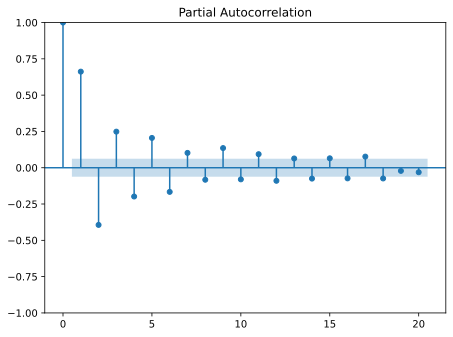

In [7]:
sm.graphics.tsa.plot_pacf(arma_process, lags = 20)
plt.tight_layout()

we see the sinusoidal pattern again so we would not be able to calc $p$ from here

As explained in the notes we'll use AIC to determine $p$ and $q$. What is AIC? check the notes :)

In [8]:
# create a list for our possible values of p and q
ps = range(0, 4)
qs = range(0, 4)

# list of all unique combinations of the lists above
order_l = list(itertools.product(ps, qs))

In [9]:
def optimize_arma(
        endog: pd.Series | list, order_l: list) -> pd.DataFrame:
    '''
    Given a list of combinations of p,q test different combinations of arma
    orders, and compare them against each other using Akaike Information
    criterion.

    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param order_l list: list of all combinations of p and q

    :returns: dataframe with two columns, one the combination of p and q,
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in order_l:
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog, 
                order = (order[0], 0, order[1]),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

In [10]:
result_df = optimize_arma(arma_process, order_l)
result_df

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.861752
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


We can see that the top candidate is 1,1 which we know is true becuase we simulated an ARMA process of that order

next steps:

- get residuals
- plot q-q plot
- get ljung-box statistic

In [11]:
model = sm.tsa.statespace.SARIMAX(
    arma_process, 
    order = (1, 0, 1),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

with the Q-Q plot we will compare our resdiuals to a normal distribution to see if they represent white noise

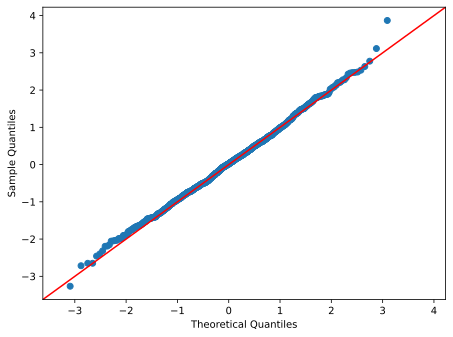

In [12]:
sm.qqplot(residuals, line = '45')
plt.tight_layout()

It look a hell of a lot similar to the normal distribution, so we are in the right track. There is another function that displays more plots on the residuals

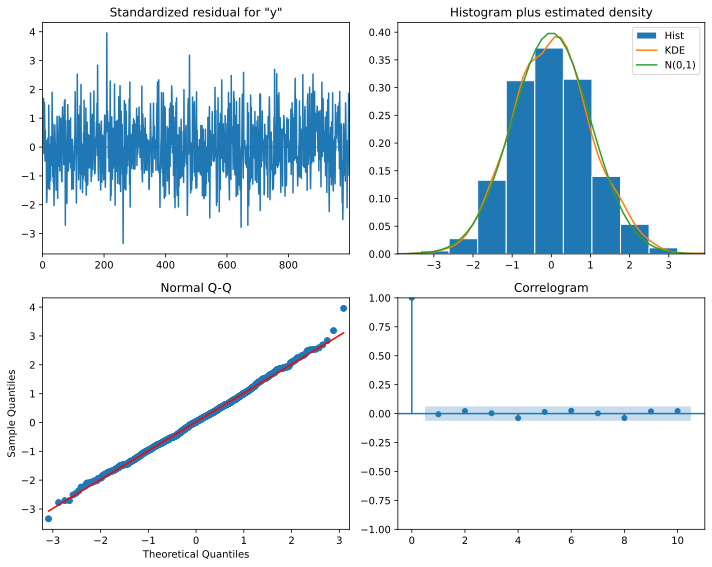

In [13]:
model.plot_diagnostics(figsize = (10, 8))
plt.tight_layout()

1. top left, the residuals are stationary they dont have any trend, this is good, because that is the behaviour of a normal dist
2. top right, histogram with the residuals, it looks like a normal distribution
3. bottom left, q-q plot
4. autocorrelation function of the residuals

we are just missing the ljung-box statistic

In [14]:
sm.stats.acorr_ljungbox(residuals, lags = [10])

,lb_stat,lb_pvalue
10,5.246805,0.874093


> The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently dis- tributed and uncorrelated.

# forecasting bandwidth usage

bandwidth is defined as the max rate of data than can be transfered (bits per second)

In [15]:
df = pd.read_csv('bandwidth.csv')

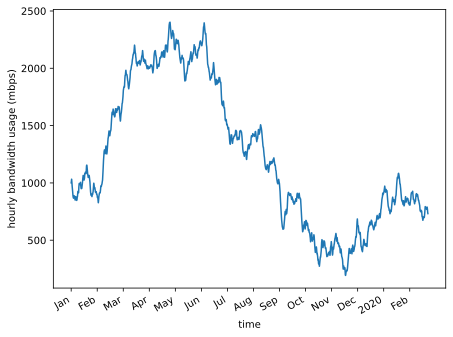

In [16]:
fig, ax = plt.subplots()

ax.plot(df.hourly_bandwidth)
ax.set_xlabel('time')
ax.set_ylabel('hourly bandwidth usage (mbps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
     'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb']
)

fig.autofmt_xdate()
plt.tight_layout()

We can see trends in the data, so it must not be stationary, nevertheless let's check this with an ADF test

In [17]:
adf = sm.tsa.stattools.adfuller(df.hourly_bandwidth)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -0.8714653199452703
p-value 0.7972240255014562


So p value is larger than 0.05 meaning we can not reject the null hypothesis an the series is not stationary. Let's transform it

In [18]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n = 1)

In [19]:
adf = sm.tsa.stattools.adfuller(bandwidth_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -20.694853863788985
p-value 0.0


Now our dataset is stationary, the book does not say it, but let's plot acf to see how it looks

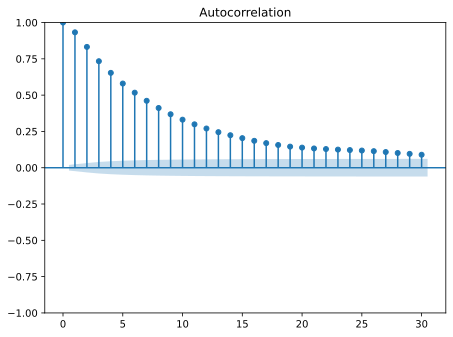

In [20]:
sm.graphics.tsa.plot_acf(bandwidth_diff, lags = 30)
plt.tight_layout()

We can see a high correlation after lag 0, so the process is not a random walk

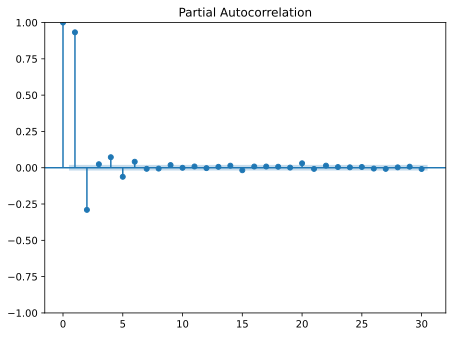

In [21]:
sm.graphics.tsa.plot_pacf(bandwidth_diff, lags = 30)
plt.tight_layout()

hmmm, so as expected we can not get the order for AR from this plot do to its sinusoidal nature, we'll have to use the new method we did with our sim above. Okay let's go back to what the books says do. Let's plot the diff series and the normal one side by side

In [22]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


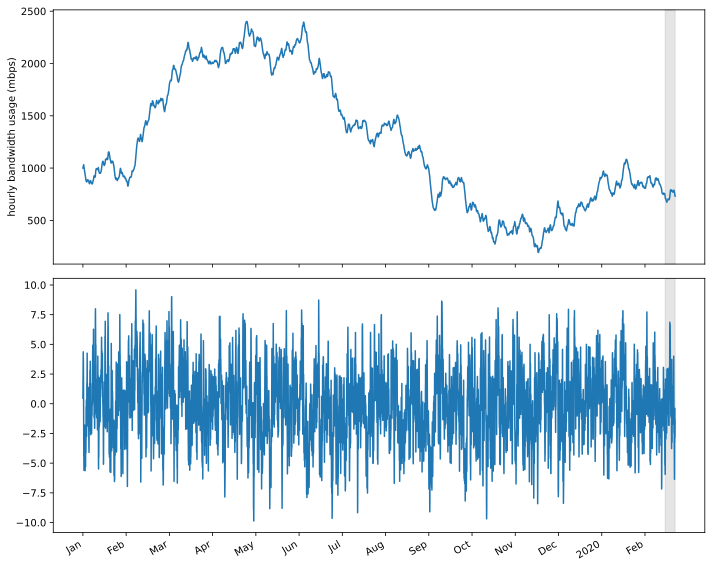

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))

ax1.plot(df.hourly_bandwidth)
ax1.set_xlabel('time')
ax1.set_ylabel('hourly bandwidth usage (mbps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(bandwidth_diff)
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)


plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
     'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb']
)

fig.autofmt_xdate()
plt.tight_layout()

We'll use our function `optimize_arma()` to find q and p for this series. First we need to define all the combinations we want to try, so:

In [24]:
# create a list for our possible values of p and q
ps = range(0, 4)
qs = range(0, 4)

# list of all unique combinations of the lists above
order_l = list(itertools.product(ps, qs))

In [25]:
result_df = optimize_arma(train.bandwidth_diff, order_l)
result_df

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155497
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


so $p = 3$ and $q = 2$ you might think, nevertheless AIC in (3,2), (2,3) and (2,2) is pretty similar, the author recommends using $p = 2$ and $q = 2$ since the model it less complex.

Let's build the model $ARMA(2,2)$ then

In [26]:
model = sm.tsa.statespace.SARIMAX(
    arma_process, 
    order = (2, 0, 2),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

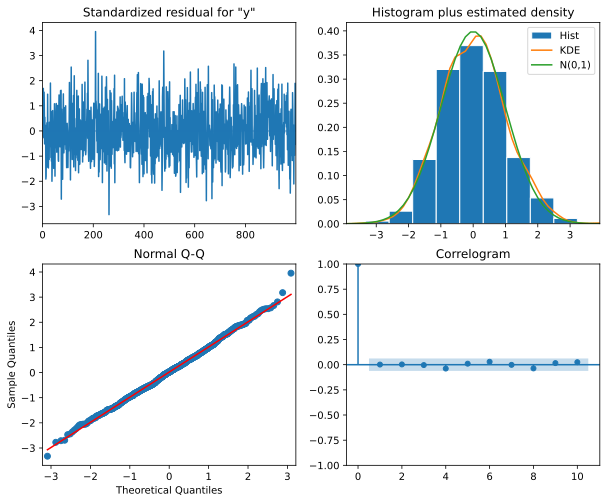

In [27]:
model.plot_diagnostics(figsize=(10, 8));

so in the Q-Q plot we can see that mostly $x = y$ meaning that our error terms behave like a normal distribution, which is what we want, to have our errors be white noise. Also it has no correlation and the historgram also shows a normal distribution. We just need to get the Ljung-box statistic to conclude the exercise 

In [28]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,0.002254,0.962131
2,0.009819,0.995102
3,0.018143,0.999354
4,1.488453,0.828685
5,1.590519,0.902393
6,2.465398,0.872320
7,2.468101,0.929480
8,3.863615,0.869214
9,4.117706,0.903496
10,4.713509,0.909476


p value is larger than 0.05 meaning we cannot reject the null hipothesis, therefore our data is uncorrelated and independently distributed

Now that we know we can use $ARMA(2,2)$ we can will forecast the next 2 hours of bandwidth usage over 7 days.

In [29]:
import tqdm

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                     window: int, method: str) -> list:
    '''
    given a dataset, forecast using one of three methods:

        1. historical mean (mean)
        2. last value  (last)
        3. ARMA(2,2) (arma)
    
    the training length will be updated with each iteration as if we were
    seeing new observations

    :param pd.DataFrame df: data frame with two columns
    :param int train_len: number of data point that can be used to fit the
                          model
    :param int horizon: length of the test set, how many values we want to
                        predict
    :param int window: how many timesteps are predicted at a time
    :param int method: mean | last | AR, method used to do the forecast

    :return:
    :rtype: list
    '''

    # train length + the horizon make the total length of the dataset
    # meaning it includes the prediction as well
    total_len = train_len + horizon

    if method.lower() == 'mean':
        pred_mean = []

        # go from last train value to total length, step by step
        for i in range(train_len, total_len, window):
            # this means calculating the mean thru each timestep
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range (window))

        return pred_mean

    if method.lower() == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    if method.lower() == 'arma':
        print('im here')
        pred_ma = []

        # tqdm part adds a progressbar, really helpful :)
        for i in  tqdm.tqdm_notebook(range(train_len, total_len, window)):
            # the order specifies an ARMA(3,3) model.
            model = sm.tsa.statespace.SARIMAX(df[:i], order = (2, 0, 2))
            r = model.fit(disp = False)
            predictions = r.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ma.extend(oos_pred)

        return pred_ma

    return []

In [30]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean') 
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_arma = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')


test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_arma'] = pred_arma

im here


  0%|          | 0/84 [00:00<?, ?it/s]

In [31]:
test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_arma
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


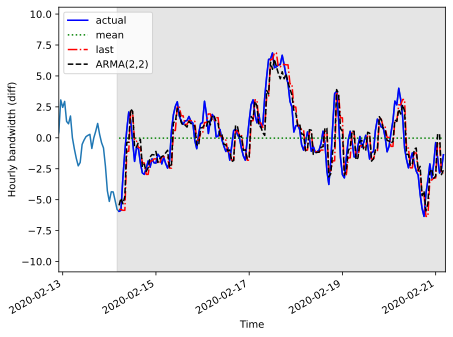

In [32]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])

ax.plot(test['bandwidth_diff'], 'b-', label = 'actual')
ax.plot(test['pred_mean'], 'g:', label = 'mean')
ax.plot(test['pred_last_value'], 'r-.', label = 'last')
ax.plot(test['pred_arma'], 'k--', label = 'ARMA(2,2)')

ax.legend(loc = 2)

ax.set_ylabel('Hourly bandwidth (diff)')
ax.set_xlabel('Time')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)


plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [33]:
mse_mean = sklearn.metrics.mean_squared_error(test.bandwidth_diff, test.pred_mean)
mse_last = sklearn.metrics.mean_squared_error(test.bandwidth_diff, test.pred_last_value)
mse_arma = sklearn.metrics.mean_squared_error(test.bandwidth_diff, test.pred_arma)

print(f'MSE:\nmean {mse_mean}\nlast value {mse_last}\n arma(2,2)) {mse_arma}')

MSE:
mean 6.306526957989325
last value 2.2297582947733656
 arma(2,2)) 1.7690462114297492


obviously $ARMA(2,2)$ is the best model, let's tranform back our series

In [35]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_arma'].cumsum()

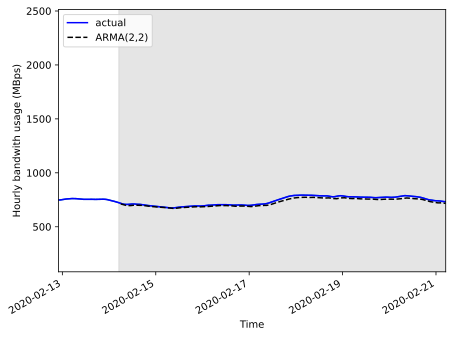

In [36]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label = 'actual')
ax.plot(df['pred_bandwidth'], 'k--', label = 'ARMA(2,2)')

ax.legend(loc = 2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color = '#808080', alpha = 0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

Finally we have the error

In [37]:
mae_arma_undiff = sklearn.metrics.mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])
print(mae_arma_undiff)

14.000362773336704


Meaning that on average our model predicts 14 Mbps above or bellow the actual value